In [ ]:
# Vấn đề: một lần split có thể "may mắn" hoặc "xui xẻo"
# → Kết quả không đại diện cho model thực sự

# Giải pháp: Cross-Validation
# Chia data thành k folds, train k lần, mỗi lần 1 fold làm test


In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
data = fetch_california_housing()
X, y = data.data, data.target

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation với 5 folds
model = LinearRegression()
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')

print("R² scores for each fold:", scores)
print(f"Mean R²: {scores.mean():.4f} ± {scores.std():.4f}")


R² scores for each fold: [0.54866323 0.46820691 0.55078434 0.53698703 0.66051406]
Mean R²: 0.5530 ± 0.0617


In [2]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    # Split data
    X_train_fold = X_scaled[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_train_fold = y[train_idx]
    y_val_fold = y[val_idx]
    
    # Train và evaluate
    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)
    score = model.score(X_val_fold, y_val_fold)
    
    fold_scores.append(score)
    print(f"Fold {fold}: R² = {score:.4f}")

print(f"\nMean R²: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")


Fold 1: R² = 0.5758
Fold 2: R² = 0.6137
Fold 3: R² = 0.6086
Fold 4: R² = 0.6213
Fold 5: R² = 0.5875

Mean R²: 0.6014 ± 0.0170


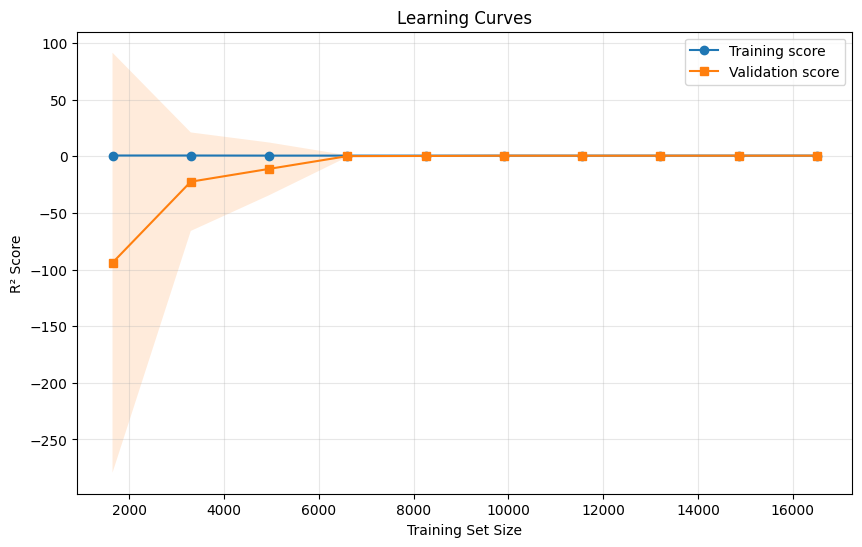

In [3]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Tạo learning curves
train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(), 
    X_scaled, 
    y, 
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2'
)

# Tính mean và std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, val_mean, label='Validation score', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)

plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [4]:
# Dựa vào learning curves:

def diagnose_model(train_scores, val_scores):
    """Chẩn đoán model từ learning curves"""
    train_final = train_scores[-1].mean()
    val_final = val_scores[-1].mean()
    gap = train_final - val_final
    
    print(f"Final training score: {train_final:.4f}")
    print(f"Final validation score: {val_final:.4f}")
    print(f"Gap: {gap:.4f}")
    
    if gap > 0.1 and train_final > 0.7:
        print("\n⚠️  OVERFITTING detected!")
        print("→ Try: Regularization, more data, fewer features")
    elif train_final < 0.6 and val_final < 0.6:
        print("\n⚠️  UNDERFITTING detected!")
        print("→ Try: More features, polynomial features, complex model")
    else:
        print("\n✅ Model looks reasonable")

diagnose_model(train_scores, val_scores)


Final training score: 0.6071
Final validation score: 0.5530
Gap: 0.0541

✅ Model looks reasonable


In [5]:
from sklearn.model_selection import cross_validate

# Evaluate nhiều metrics cùng lúc
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(
    LinearRegression(), 
    X_scaled, 
    y, 
    cv=5, 
    scoring=scoring
)

print("Cross-Validation Results:")
print("-" * 50)
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    # Với neg_* metrics, đổi dấu để dễ đọc
    if metric.startswith('neg_'):
        scores = -scores
        metric_name = metric.replace('neg_', '').upper()
    else:
        metric_name = metric.upper()
    
    print(f"{metric_name:20} | {scores.mean():.4f} ± {scores.std():.4f}")


Cross-Validation Results:
--------------------------------------------------
R2                   | 0.5530 ± 0.0617
MEAN_SQUARED_ERROR   | 0.5583 ± 0.0656
MEAN_ABSOLUTE_ERROR  | 0.5475 ± 0.0218


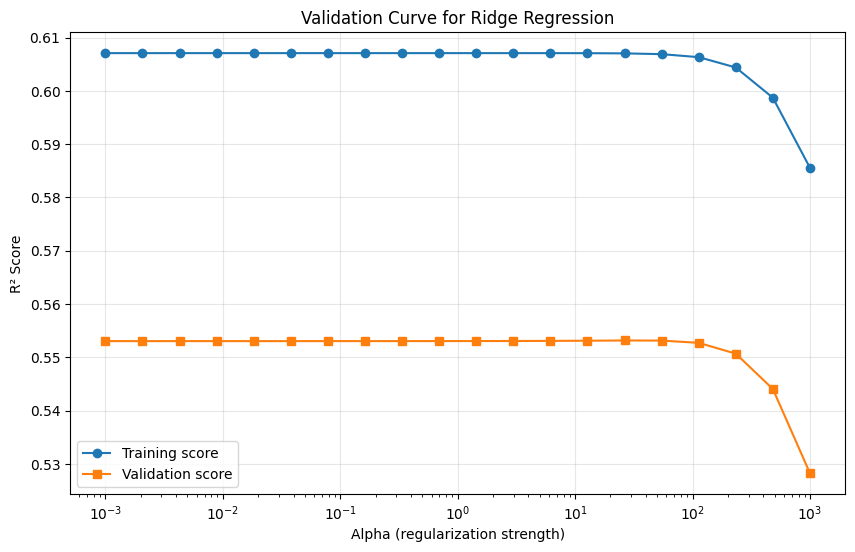

Best alpha: 26.367


In [6]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

# Test nhiều giá trị alpha cho Ridge
alphas = np.logspace(-3, 3, 20)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_scores, val_scores = validation_curve(
    Ridge(),
    X_scaled,
    y,
    param_name='alpha',
    param_range=alphas,
    cv=5,
    scoring='r2'
)

# Plot
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, train_scores.mean(axis=1), label='Training score', marker='o')
plt.semilogx(alphas, val_scores.mean(axis=1), label='Validation score', marker='s')
plt.xlabel('Alpha (regularization strength)')
plt.ylabel('R² Score')
plt.title('Validation Curve for Ridge Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Tìm alpha tốt nhất
best_alpha = alphas[val_scores.mean(axis=1).argmax()]
print(f"Best alpha: {best_alpha:.3f}")
